<h2>Importing modules required for running the code</h2>

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, gc
# from tqdm import tqdm
import hashlib
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,Flatten
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

In [2]:
print(tf.__version__)

2.15.0


#### TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tf.config.list_logical_devices('TPU'))
except ValueError:
    tpu = None

    
if tpu:
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_physical_devices('GPU'))>1:
    strategy = tf.distribute.MirroredStrategy()
    print(tf.config.list_physical_devices('GPU'))
else:
    # Default distribution strategy in TensorFlow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
data_exp=False
bin_clas=False
es_acc=True
from_split_files=False

!python --version

Python 3.10.13


In [5]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             4
On-line CPU(s) list:                0-3
Thread(s) per core:                 2
Core(s) per socket:                 2
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              79
Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                           0
CPU MHz:                            2200.226
BogoMIPS:                           4400.45
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          64 KiB
L1i cache:                          64 KiB
L2 cache:                           512 KiB
L3 cache:                

<h2> Data exploration before uniting files </h2>

In [6]:
if data_exp:
    # Define the input directory
    input_dir = "/kaggle/input/awid3-csv-wlan-only/CSV"

    # Get the list of folders
    folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]

    # Initialize a dictionary to hold unique values for each column
    unique_values = {}

    # Read files one by one
    for folder in folders:
        # Get the list of CSV files in the folder
        files = [f for f in os.listdir(os.path.join(input_dir, folder)) if f.endswith('.csv')]

        for file in files:
            file_path = os.path.join(input_dir, folder, file)

            # Read the file
            df = pd.read_csv(file_path, low_memory=False)

            # For each column, calculate unique values and add them to the set
            for column in df.columns:
                if column not in unique_values:
                    unique_values[column] = set()
    #             unique_values[column].update(df[column].unique())
                unique_values[column].update(df[column].dropna().unique())

In [7]:
if data_exp:
    # Iterate over the unique_values dictionary
    for column, values in unique_values.items():
        # If the set of unique values has less than 10 elements
        if len(values) < 10:
            print(f"Column: {column}, Unique Values: {values}")

<h2> Training Dataset </h2>

In [8]:
if from_split_files==False:
    if bin_clas == False:
        # Define the input and output directories
        output_dir = "/kaggle/working/CSV"
        awid = pd.read_csv("/kaggle/input/awid3-csv-wlan-only/CSV/awid_full.csv", low_memory=False)

In [9]:
if from_split_files==True:
    if bin_clas == False:
        # Define the input and output directories
        input_dir = "/kaggle/input/awid3-csv-wlan-only/CSV"
        output_dir = "/kaggle/working/CSV"

        # Get the list of folders
        folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]

        # Initialize the final DataFrame
        awid = pd.DataFrame()

        # Read and concatenate files directly into the 'awid' DataFrame
        for folder in folders:
            # Get the list of CSV files in the folder
            files = [f for f in os.listdir(os.path.join(input_dir, folder)) if f.endswith('.csv')]

        #     for file in tqdm(files, desc=f"Processing files in {folder}"):
            for file in files:
                # Read the CSV file and immediately concatenate it
                df = pd.read_csv(os.path.join(input_dir, folder, file), low_memory=False)
                
                awid = pd.concat([awid, df], ignore_index=True)

In [10]:
if from_split_files==False:
    if bin_clas == True:
        # Define the input and output directories
        output_dir = "/kaggle/working/CSV"
        awid = pd.read_csv("/kaggle/input/awid3-csv-wlan-only/CSV/awid_full.csv", low_memory=False)
        awid['Label'] = awid['Label'].apply(lambda x: 0 if x == 'Normal' else 1)

In [11]:
if from_split_files==True:
    if bin_clas == True:
        # Define the input and output directories
        input_dir = "/kaggle/input/awid3-csv-wlan-only/CSV"
        output_dir = "/kaggle/working/CSV"

        # Get the list of folders
        folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]

        # Initialize the final DataFrame
        awid = pd.DataFrame()

        # Read and concatenate files directly into the 'awid' DataFrame
        for folder in folders:
            # Get the list of CSV files in the folder
            files = [f for f in os.listdir(os.path.join(input_dir, folder)) if f.endswith('.csv')]

        #     for file in tqdm(files, desc=f"Processing files in {folder}"):
            for file in files:
                # Read the CSV file and immediately concatenate it
                df = pd.read_csv(os.path.join(input_dir, folder, file), low_memory=False)
                
                # Binary classification
                df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Normal' else 1)
                awid = pd.concat([awid, df], ignore_index=True)

In [12]:
if from_split_files==True:
    # df = None
    del df
    gc.collect()

<h2>Columns Name for our testing and training data </h2>

In [13]:
# features = awid.columns
print(awid.columns)

Index(['frame.len', 'frame.number', 'frame.time_delta_displayed',
       'frame.time_epoch', 'frame.time_relative', 'wlan.duration',
       'wlan.fc.ds', 'wlan.fc.protected', 'wlan.fc.type', 'wlan.fc.retry',
       'wlan.fc.subtype', 'wlan.fixed.reason_code', 'wlan.fixed.timestamp',
       'wlan.seq', 'wlan_radio.data_rate', 'wlan_radio.end_tsf',
       'wlan_radio.start_tsf', 'wlan.rsn.capabilities.mfpc',
       'wlan_rsna_eapol.keydes.msgnr', 'wlan_rsna_eapol.keydes.data_len',
       'wlan_rsna_eapol.keydes.key_info.key_mic', 'eapol.keydes.key_len',
       'eapol.keydes.replay_counter', 'eapol.len', 'eapol.type', 'Label',
       'wlan.bssid_hashed', 'wlan.da_hashed', 'wlan.ra_hashed',
       'wlan.sa_hashed', 'wlan.ta_hashed', 'data.len_filtered',
       'wlan.analysis.kck_hashed', 'wlan.analysis.kek_hashed',
       'wlan.rsn.ie.gtk.key_hashed', 'wlan.rsn.ie.igtk.key_hashed',
       'wlan.rsn.ie.pmkid_hashed', 'wlan_rsna_eapol.keydes.nonce_hashed',
       'wlan_rsna_eapol.keydes.data

<h2> Data Exploration</h2>

In [14]:
pd.set_option('display.max_columns', None)
awid.head()

,frame.len,frame.number,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,wlan.duration,wlan.fc.ds,wlan.fc.protected,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.fixed.reason_code,wlan.fixed.timestamp,wlan.seq,wlan_radio.data_rate,wlan_radio.end_tsf,wlan_radio.start_tsf,wlan.rsn.capabilities.mfpc,wlan_rsna_eapol.keydes.msgnr,wlan_rsna_eapol.keydes.data_len,wlan_rsna_eapol.keydes.key_info.key_mic,eapol.keydes.key_len,eapol.keydes.replay_counter,eapol.len,eapol.type,Label,wlan.bssid_hashed,wlan.da_hashed,wlan.ra_hashed,wlan.sa_hashed,wlan.ta_hashed,data.len_filtered,wlan.analysis.kck_hashed,wlan.analysis.kek_hashed,wlan.rsn.ie.gtk.key_hashed,wlan.rsn.ie.igtk.key_hashed,wlan.rsn.ie.pmkid_hashed,wlan_rsna_eapol.keydes.nonce_hashed,wlan_rsna_eapol.keydes.data_bool,data.data_bool
0,76.0,1000001.0,0.000134,1.608066e+09,358.292267,226.0,0,0.0,1.0,0.0,11.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,0,0,88230085263763,0,13870904442420,0.0,0,0,0,0,0,0.0,False,False
1,70.0,1000002.0,0.000011,1.608066e+09,358.292278,184.0,0,0.0,1.0,0.0,12.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,0,0,13870904442420,0,0,0.0,0,0,0,0,0,0.0,False,False
2,1550.0,1000003.0,0.000226,1.608066e+09,358.292504,48.0,2,1.0,2.0,1.0,8.0,-1.0,0.0,1508.0,156.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,13870904442420,88230085263763,88230085263763,13870904442416,13870904442420,0.0,0,0,0,0,0,0.0,False,False
3,88.0,1000004.0,0.000007,1.608066e+09,358.292511,6.0,0,0.0,1.0,0.0,9.0,-1.0,0.0,-1.0,54.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,0,0,13870904442420,0,88230085263763,0.0,0,0,0,0,0,0.0,False,False
4,76.0,1000005.0,0.000206,1.608066e+09,358.292717,158.0,0,0.0,1.0,0.0,11.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,0,0,88230085205950,0,13870904442420,0.0,0,0,0,0,0,0.0,False,False


In [15]:
if data_exp:
    awid.describe()

In [16]:
if data_exp:
    awid.describe(include='all').loc['unique', :]

In [17]:
len(awid)

15574909

In [18]:
if data_exp:
    awid['Label'].value_counts()

In [19]:
# if data_exp:
awid.isna().sum()

frame.len                                  0
frame.number                               0
frame.time_delta_displayed                 0
frame.time_epoch                           0
frame.time_relative                        0
wlan.duration                              0
wlan.fc.ds                                 0
wlan.fc.protected                          0
wlan.fc.type                               0
wlan.fc.retry                              0
wlan.fc.subtype                            0
wlan.fixed.reason_code                     0
wlan.fixed.timestamp                       0
wlan.seq                                   0
wlan_radio.data_rate                       0
wlan_radio.end_tsf                         0
wlan_radio.start_tsf                       0
wlan.rsn.capabilities.mfpc                 0
wlan_rsna_eapol.keydes.msgnr               0
wlan_rsna_eapol.keydes.data_len            0
wlan_rsna_eapol.keydes.key_info.key_mic    0
eapol.keydes.key_len                       0
eapol.keyd

In [20]:
if data_exp:    
    print(awid.apply(lambda col: col.unique()))

In [21]:
if data_exp:
    pd.Series({col:awid[col].unique() for col in awid})

In [22]:
# if data_exp:
awid['Label'].value_counts()

Label
Normal       15107404
Kr00k          191803
Evil_Twin      104827
Disas           75131
Krack           49990
Deauth          38942
(Re)Assoc        5502
RogueAP          1310
Name: count, dtype: int64

<h2>Converting all the Columns to numeric</h2>

In [23]:
# for col in awid.columns:
#     awid[col]=pd.to_numeric(awid[col], errors='ignore')

In [24]:
bool_cols = ["wlan_rsna_eapol.keydes.data_bool","data.data_bool"]  # replace with your boolean column names

for col in bool_cols:
    awid[col] = awid[col].astype(int)

In [25]:
for col in awid.select_dtypes(exclude=['number']).columns:
        print(f"Column: {col}, Type: {awid[col].dtype}")

Column: Label, Type: object


In [26]:
awid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15574909 entries, 0 to 15574908
Data columns (total 40 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   frame.len                                float64
 1   frame.number                             float64
 2   frame.time_delta_displayed               float64
 3   frame.time_epoch                         float64
 4   frame.time_relative                      float64
 5   wlan.duration                            float64
 6   wlan.fc.ds                               int64  
 7   wlan.fc.protected                        float64
 8   wlan.fc.type                             float64
 9   wlan.fc.retry                            float64
 10  wlan.fc.subtype                          float64
 11  wlan.fixed.reason_code                   float64
 12  wlan.fixed.timestamp                     float64
 13  wlan.seq                                 float64
 14  wlan_radio.data_

In [27]:
awid.select_dtypes(['number']).head()

,frame.len,frame.number,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,wlan.duration,wlan.fc.ds,wlan.fc.protected,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.fixed.reason_code,wlan.fixed.timestamp,wlan.seq,wlan_radio.data_rate,wlan_radio.end_tsf,wlan_radio.start_tsf,wlan.rsn.capabilities.mfpc,wlan_rsna_eapol.keydes.msgnr,wlan_rsna_eapol.keydes.data_len,wlan_rsna_eapol.keydes.key_info.key_mic,eapol.keydes.key_len,eapol.keydes.replay_counter,eapol.len,eapol.type,wlan.bssid_hashed,wlan.da_hashed,wlan.ra_hashed,wlan.sa_hashed,wlan.ta_hashed,data.len_filtered,wlan.analysis.kck_hashed,wlan.analysis.kek_hashed,wlan.rsn.ie.gtk.key_hashed,wlan.rsn.ie.igtk.key_hashed,wlan.rsn.ie.pmkid_hashed,wlan_rsna_eapol.keydes.nonce_hashed,wlan_rsna_eapol.keydes.data_bool,data.data_bool
0,76.0,1000001.0,0.000134,1.608066e+09,358.292267,226.0,0,0.0,1.0,0.0,11.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,88230085263763,0,13870904442420,0.0,0,0,0,0,0,0.0,0,0
1,70.0,1000002.0,0.000011,1.608066e+09,358.292278,184.0,0,0.0,1.0,0.0,12.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,13870904442420,0,0,0.0,0,0,0,0,0,0.0,0,0
2,1550.0,1000003.0,0.000226,1.608066e+09,358.292504,48.0,2,1.0,2.0,1.0,8.0,-1.0,0.0,1508.0,156.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13870904442420,88230085263763,88230085263763,13870904442416,13870904442420,0.0,0,0,0,0,0,0.0,0,0
3,88.0,1000004.0,0.000007,1.608066e+09,358.292511,6.0,0,0.0,1.0,0.0,9.0,-1.0,0.0,-1.0,54.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,13870904442420,0,88230085263763,0.0,0,0,0,0,0,0.0,0,0
4,76.0,1000005.0,0.000206,1.608066e+09,358.292717,158.0,0,0.0,1.0,0.0,11.0,-1.0,0.0,-1.0,24.0,7.953740e+09,7.953740e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,88230085205950,0,13870904442420,0.0,0,0,0,0,0,0.0,0,0


In [28]:
for col in awid.columns:
    if pd.api.types.is_numeric_dtype(awid[col]):
        info = np.iinfo(awid[col].dtype) if 'int' in str(awid[col].dtype) else np.finfo(awid[col].dtype)
        if awid[col].min() >= info.min and awid[col].max() <= info.max:
            awid[col] = pd.to_numeric(awid[col], downcast='integer')
            awid[col] = pd.to_numeric(awid[col], downcast='float')

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


In [29]:
awid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15574909 entries, 0 to 15574908
Data columns (total 40 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   frame.len                                int16  
 1   frame.number                             float32
 2   frame.time_delta_displayed               float32
 3   frame.time_epoch                         float64
 4   frame.time_relative                      float32
 5   wlan.duration                            int16  
 6   wlan.fc.ds                               int8   
 7   wlan.fc.protected                        int8   
 8   wlan.fc.type                             int8   
 9   wlan.fc.retry                            int8   
 10  wlan.fc.subtype                          int8   
 11  wlan.fixed.reason_code                   float32
 12  wlan.fixed.timestamp                     float64
 13  wlan.seq                                 int16  
 14  wlan_radio.data_

In [30]:
awid.select_dtypes(['number']).head()

,frame.len,frame.number,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,wlan.duration,wlan.fc.ds,wlan.fc.protected,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.fixed.reason_code,wlan.fixed.timestamp,wlan.seq,wlan_radio.data_rate,wlan_radio.end_tsf,wlan_radio.start_tsf,wlan.rsn.capabilities.mfpc,wlan_rsna_eapol.keydes.msgnr,wlan_rsna_eapol.keydes.data_len,wlan_rsna_eapol.keydes.key_info.key_mic,eapol.keydes.key_len,eapol.keydes.replay_counter,eapol.len,eapol.type,wlan.bssid_hashed,wlan.da_hashed,wlan.ra_hashed,wlan.sa_hashed,wlan.ta_hashed,data.len_filtered,wlan.analysis.kck_hashed,wlan.analysis.kek_hashed,wlan.rsn.ie.gtk.key_hashed,wlan.rsn.ie.igtk.key_hashed,wlan.rsn.ie.pmkid_hashed,wlan_rsna_eapol.keydes.nonce_hashed,wlan_rsna_eapol.keydes.data_bool,data.data_bool
0,76,1000001.0,0.000134,1.608066e+09,358.292267,226,0,0,1,0,11,-1.0,0.0,-1,24.0,7.953740e+09,7.953740e+09,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,8.823009e+13,0.000000e+00,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,70,1000002.0,0.000011,1.608066e+09,358.292267,184,0,0,1,0,12,-1.0,0.0,-1,24.0,7.953740e+09,7.953740e+09,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,1.387090e+13,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,1550,1000003.0,0.000226,1.608066e+09,358.292511,48,2,1,2,1,8,-1.0,0.0,1508,156.0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,8.823009e+13,8.823009e+13,1.387090e+13,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,88,1000004.0,0.000007,1.608066e+09,358.292511,6,0,0,1,0,9,-1.0,0.0,-1,54.0,7.953740e+09,7.953740e+09,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,1.387090e+13,0.000000e+00,8.823009e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,76,1000005.0,0.000206,1.608066e+09,358.292725,158,0,0,1,0,11,-1.0,0.0,-1,24.0,7.953740e+09,7.953740e+09,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,8.823009e+13,0.000000e+00,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


<h2>Splitting the training data</h2>

In [31]:
# X_train, y_train = awid.select_dtypes(['number']), awid['Label']
# X, y = awid.select_dtypes(['number']), awid['Label']
# X, y = awid.drop(columns=["Label"]), awid['Label']
# X, y = awid.drop(columns=["Label","wlan_rsna_eapol.keydes.nonce_hashed","wlan.rsn.ie.igtk.key_hashed","wlan.rsn.ie.gtk.key_hashed","wlan_rsna_eapol.keydes.data_bool","data.data_bool"]), awid['Label']
# X, y = awid.drop(columns=["Label","wlan_rsna_eapol.keydes.nonce_hashed","wlan_rsna_eapol.keydes.data_bool","data.data_bool"]), awid['Label']
# X, y = awid.drop(columns=["Label","wlan_rsna_eapol.keydes.data_bool","data.data_bool"]), awid['Label']
X, y = awid.drop(columns=["Label"]), awid['Label']
sc=StandardScaler()
sc.fit(X)

StandardScaler()

In [32]:
del awid
gc.collect()

53

In [33]:
y.value_counts()

Label
Normal       15107404
Kr00k          191803
Evil_Twin      104827
Disas           75131
Krack           49990
Deauth          38942
(Re)Assoc        5502
RogueAP          1310
Name: count, dtype: int64

In [34]:
X.shape

(15574909, 39)

In [35]:
# Split the data into train and test sets (80% train, 20% test+val)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Split the data into validation and test sets (10% test, 10% val)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

<h2>Testing Data</h2>

In [36]:
len(X_train)

12459927

In [37]:
len(X_validation)

1557491

In [38]:
len(X_test)

1557491

In [39]:
y_train.value_counts()

Label
Normal       12085923
Kr00k          153442
Evil_Twin       83861
Disas           60105
Krack           39992
Deauth          31154
(Re)Assoc        4402
RogueAP          1048
Name: count, dtype: int64

In [40]:
y_test.value_counts()

Label
Normal       1510740
Kr00k          19181
Evil_Twin      10483
Disas           7513
Krack           4999
Deauth          3894
(Re)Assoc        550
RogueAP          131
Name: count, dtype: int64

In [41]:
y_validation.value_counts()

Label
Normal       1510741
Kr00k          19180
Evil_Twin      10483
Disas           7513
Krack           4999
Deauth          3894
(Re)Assoc        550
RogueAP          131
Name: count, dtype: int64

In [42]:
del X
del y
gc.collect()

0

<h2>Preprocessing and Feature Scaling   </h2> 

In [43]:
scaled_X_train=sc.transform(X_train)

In [44]:
X_train

,frame.len,frame.number,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,wlan.duration,wlan.fc.ds,wlan.fc.protected,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.fixed.reason_code,wlan.fixed.timestamp,wlan.seq,wlan_radio.data_rate,wlan_radio.end_tsf,wlan_radio.start_tsf,wlan.rsn.capabilities.mfpc,wlan_rsna_eapol.keydes.msgnr,wlan_rsna_eapol.keydes.data_len,wlan_rsna_eapol.keydes.key_info.key_mic,eapol.keydes.key_len,eapol.keydes.replay_counter,eapol.len,eapol.type,wlan.bssid_hashed,wlan.da_hashed,wlan.ra_hashed,wlan.sa_hashed,wlan.ta_hashed,data.len_filtered,wlan.analysis.kck_hashed,wlan.analysis.kek_hashed,wlan.rsn.ie.gtk.key_hashed,wlan.rsn.ie.igtk.key_hashed,wlan.rsn.ie.pmkid_hashed,wlan_rsna_eapol.keydes.nonce_hashed,wlan_rsna_eapol.keydes.data_bool,data.data_bool
12513151,76,440448.0,0.000158,1.607630e+09,255.192780,338,0,0,1,0,11,-1.0,0.0,-1,24.000000,1.420658e+10,1.420658e+10,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,8.823009e+13,0.000000e+00,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4787852,1610,2209179.0,0.000001,1.609009e+09,495.146637,48,2,1,2,0,8,-1.0,0.0,2162,130.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,8.823009e+13,8.823009e+13,1.387090e+13,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4958336,76,529663.0,0.000364,1.609009e+09,254.108795,178,0,0,1,0,11,-1.0,0.0,-1,12.000000,8.310946e+09,8.310946e+09,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,1.387090e+13,0.000000e+00,8.280337e+11,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1768152,420,789449.0,0.000003,1.608066e+09,323.283447,48,1,1,2,0,8,-1.0,0.0,2578,52.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,1.387090e+13,1.387090e+13,1.637305e+14,1.637305e+14,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2055478,1550,926775.0,0.000004,1.608066e+09,348.511078,48,2,1,2,0,8,-1.0,0.0,199,78.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,8.823009e+13,8.823009e+13,1.387090e+13,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14608605,76,1633694.0,0.000522,1.608310e+09,488.506531,290,0,0,1,0,11,-1.0,0.0,-1,24.000000,1.560124e+10,1.560124e+10,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,1.810834e+14,0.000000e+00,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2198875,170,1120174.0,0.000002,1.608066e+09,384.702545,48,1,1,2,0,8,-1.0,0.0,2826,173.332993,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,1.387090e+13,1.387090e+13,1.810834e+14,1.810834e+14,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
14268774,1610,243863.0,0.000004,1.608310e+09,225.732956,48,2,1,2,0,8,-1.0,0.0,3489,78.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,1.387090e+13,1.810834e+14,1.810834e+14,1.387090e+13,1.387090e+13,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
15493292,70,168384.0,0.000048,1.608310e+09,214.285858,128,0,0,1,0,12,-1.0,0.0,-1,24.000000,1.532702e+10,1.532702e+10,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,1.387090e+13,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [45]:
print(X_train.dtypes)

frame.len                                    int16
frame.number                               float32
frame.time_delta_displayed                 float32
frame.time_epoch                           float64
frame.time_relative                        float32
wlan.duration                                int16
wlan.fc.ds                                    int8
wlan.fc.protected                             int8
wlan.fc.type                                  int8
wlan.fc.retry                                 int8
wlan.fc.subtype                               int8
wlan.fixed.reason_code                     float32
wlan.fixed.timestamp                       float64
wlan.seq                                     int16
wlan_radio.data_rate                       float32
wlan_radio.end_tsf                         float64
wlan_radio.start_tsf                       float64
wlan.rsn.capabilities.mfpc                    int8
wlan_rsna_eapol.keydes.msgnr                  int8
wlan_rsna_eapol.keydes.data_len

In [46]:
scaled_X_train

array([[-0.59998832, -0.92295372, -0.04663732, ..., -0.006966  ,
        -0.00808491, -0.16229694],
       [ 1.69363132,  1.10826329, -0.10110682, ..., -0.006966  ,
        -0.00808491, -0.16229694],
       [-0.59998832, -0.82049889,  0.02483223, ..., -0.006966  ,
        -0.00808491, -0.16229694],
       ...,
       [ 1.69363132, -1.14871263, -0.100066  , ..., -0.006966  ,
        -0.00808491, -0.16229694],
       [-0.60895945, -1.23539299, -0.08480066, ..., -0.006966  ,
        -0.00808491, -0.16229694],
       [-0.58503643,  0.78306985, -0.0587802 , ..., -0.006966  ,
        -0.00808491, -0.16229694]])

In [47]:
print(scaled_X_train.dtype)

float64


In [48]:
del X_train
gc.collect()

0

In [49]:
scaled_X_test=sc.transform(X_test)

In [50]:
del X_test
gc.collect()

0

In [51]:
scaled_X_validation=sc.transform(X_validation)

In [52]:
del X_validation
gc.collect()

0

<h2>Encoding the label data</h2>

In [53]:
if bin_clas == False:
    encoder = LabelEncoder()
    encoded_y=encoder.fit_transform(y_train)
    enc_y_test=encoder.fit_transform(y_test)
    enc_y_validation=encoder.fit_transform(y_validation)

#### Don't delete y_test for confusion matrix

In [54]:
if bin_clas == False:
    del y_train
    del y_validation
    # del y_test
    gc.collect()

In [55]:
if bin_clas == False:
    encoder.classes_

In [56]:
if bin_clas == False:
    len(encoder.classes_)

In [57]:
if bin_clas == False:
    enc_y_test

<h2>Changing it to Categorical </h2>

In [58]:
if bin_clas == False:
    cat_y_train=to_categorical(encoded_y)
    cat_y_validation=to_categorical(enc_y_validation)
    cat_y_train

In [59]:
if bin_clas == False:
    del encoded_y
    del enc_y_validation
    gc.collect()

In [60]:
if bin_clas == False:
    cat_y_test=to_categorical(enc_y_test)
    cat_y_test

#### Delete enc_y_test

In [61]:
# del enc_y_test
# gc.collect()

<h2>DNN for Multiclass Classification </h2>

In [62]:
# For TPU batch size will depend on number of replicas
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync # the batch size in each epoch (128)
BATCH_SIZE=2048
print(BATCH_SIZE)

2048


In [63]:
if bin_clas == False:
    with strategy.scope():
        #Neural Network(Multiclass/Categorical Crossentropy)
        model2 = Sequential()
        model2.add(Dense(10, input_shape=(scaled_X_train.shape[1],), activation='relu'))
        model2.add(Dense(20, activation='relu'))
        model2.add(Dense(len(encoder.classes_), activation='softmax'))

        model2.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
        model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788 (3.08 KB)

 Trainable params: 788 (3.08 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
if bin_clas == True:
    with strategy.scope():
        
        model2 = Sequential()
        model2.add(Dense(10, input_shape=(scaled_X_train.shape[1],), activation='relu'))
        model2.add(Dense(20, activation='relu'))
        model2.add(Dense(1, activation='sigmoid'))  # Only one output neuron for binary classification

        model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model2.summary()

In [65]:
if es_acc == False:
    earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

In [66]:
if es_acc == True:
    earlystop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3,restore_best_weights=True)

In [ ]:
if bin_clas == False:
    hist=model2.fit(scaled_X_train,cat_y_train,batch_size=BATCH_SIZE,validation_data=(scaled_X_validation, cat_y_validation),
                   callbacks=[earlystop],epochs=50, verbose=1 )

In [ ]:
if bin_clas == True:
    hist=model2.fit(scaled_X_train,y_train,batch_size=BATCH_SIZE,validation_data=(scaled_X_validation, y_validation),
                   callbacks=[earlystop],epochs=50, verbose=1 )

In [ ]:
model2.save('my_model_v18.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
from IPython.display import FileLink
FileLink(r'my_model_v18.h5')

In [ ]:
# loss, accuracy=model2.evaluate(scaled_X_train, cat_y_train)

In [ ]:
# accuracy

In [70]:
if bin_clas == True:
    model2_loss, model2_accuracy = model2.evaluate(scaled_X_test,y_test)

In [71]:
if bin_clas == False:
    model2_loss, model2_accuracy = model2.evaluate(scaled_X_test,cat_y_test)

48672/48672 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - accuracy: 0.9996 - loss: 0.0014


In [72]:
print('Loss :{loss},\nAccuracy of DNN 2 : {accuracy}'.format(loss= model2_loss,accuracy=model2_accuracy))

Loss :0.001257268595509231,
Accuracy of DNN 2 : 0.9995794296264648


In [73]:
import matplotlib.pyplot as plt

# acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
# loss = hist.history['loss']
val_loss = hist.history['val_loss']

# epochs = range(1, len(acc) + 1)
epochs = hist.epoch

# "bo" is for "blue dot"
# plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


NameError: name 'hist' is not defined

In [ ]:
# acc_values = hist.history['accuracy']
val_acc_values = hist.history['val_accuracy']

# plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


<h2>Predicting the Model</h2>

In [74]:
if bin_clas == False:
    model2_pred = model2.predict(scaled_X_test).argmax(axis=1)

48672/48672 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step


In [75]:
if bin_clas == False:
    print(np.unique(encoder.inverse_transform(model2_pred), return_counts=True))

(array(['(Re)Assoc', 'Deauth', 'Disas', 'Evil_Twin', 'Kr00k', 'Krack',
       'Normal', 'RogueAP'], dtype=object), array([    550,    3889,    7517,   10510,   19178,    4850, 1510866,
           131]))


In [76]:
if bin_clas == False:
    print(encoder.classes_)

['(Re)Assoc' 'Deauth' 'Disas' 'Evil_Twin' 'Kr00k' 'Krack' 'Normal'
 'RogueAP']


In [77]:
if bin_clas == True:
    model2_pred = (model2.predict(scaled_X_test) > 0.5).astype(int)
    print(np.unique(model2_pred, return_counts=True))

In [ ]:
# transpose_model2=np.transpose([enc_y_test, model2_pred])

In [ ]:
# transpose_model2

<h2>Generating the Results </h2>

In [ ]:
# target_names=[encoder.classes_[0], encoder.classes_[1], encoder.classes_[2]]

In [111]:
if bin_clas == False:
    result_model2= classification_report(encoder.inverse_transform(enc_y_test), encoder.inverse_transform(model2_pred))
    # result_model2= classification_report(np.argmax(cat_y_test, axis=1), model2_pred, target_names= list(encoder.classes_))

In [79]:
if bin_clas == True:
    result_model2= classification_report(y_test, model2_pred, target_names= ['Normal', 'Malicious'])
    # result_model2= classification_report(np.argmax(cat_y_test, axis=1), model2_pred, target_names= list(encoder.classes_))

In [112]:
print(result_model2)

              precision    recall  f1-score   support

   (Re)Assoc       1.00      1.00      1.00       550
      Deauth       1.00      1.00      1.00      3894
       Disas       1.00      1.00      1.00      7513
   Evil_Twin       1.00      1.00      1.00     10483
       Kr00k       1.00      1.00      1.00     19181
       Krack       0.96      0.93      0.94      4999
      Normal       1.00      1.00      1.00   1510740
     RogueAP       1.00      1.00      1.00       131

    accuracy                           1.00   1557491
   macro avg       0.99      0.99      0.99   1557491
weighted avg       1.00      1.00      1.00   1557491



## Confusion Matrix

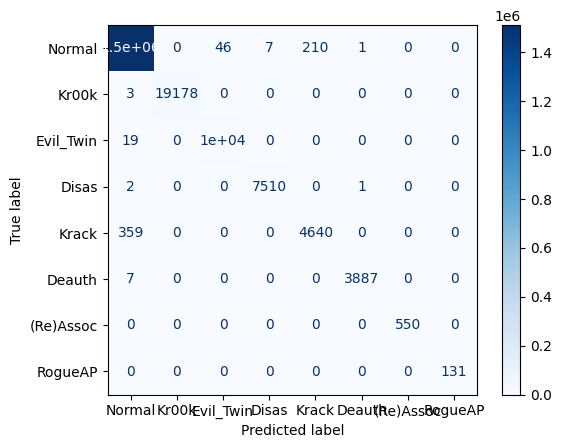

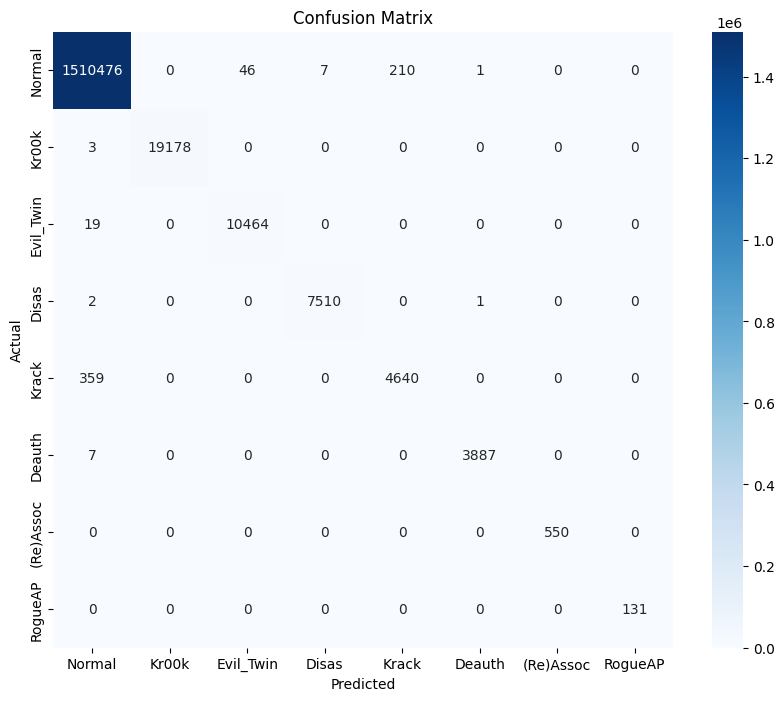

In [136]:
if bin_clas == False:
    class_label = ["Normal", "Kr00k", "Evil_Twin", "Disas", "Krack", "Deauth", "(Re)Assoc", "RogueAP"]
#     class_label =list(encoder.classes_)
    # get confusion matrix 
    cm = confusion_matrix(y_test,
                          encoder.inverse_transform(model2_pred), labels = class_label)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Visualize confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_label, yticklabels=class_label)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [116]:
if bin_clas == True:
    class_label = ['Normal', 'Malicious']
    # get confusion matrix 
    cm = confusion_matrix(y_test, model2_pred)
    # covert it to dataframe for plotting
    cm_df = pd.DataFrame(cm, 
                         index = class_label, 
                         columns = class_label)
    # plot it 
    plt.figure(figsize = (10,8))
    g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
    g.xaxis.set_ticks_position("top")
    g.tick_params(axis='x', rotation=90)
    g.set_xlabel("True Label")
    g.set_ylabel("Predicted Label")

<h2>Reshaping to the array to 3-Dimensional array  </h2>

In [117]:
# #Reshape input to be [samples, time steps, features] to work with LSTM

# third_X_train = np.reshape(scaled_X_train, (scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
# third_X_train.shape

In [118]:
# third_X_test = np.reshape(scaled_X_test,(scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))
# third_X_test.shape

<h2>Using Recurrent Neural Network with LSTM </h2>

In [119]:
# #Using multiple layer of LSTM
# multi_lstm_model=Sequential()

# multi_lstm_model.add(LSTM(10,input_shape=(1, third_X_train.shape[2]),
#                     return_sequences=True, activation='relu'))
# multi_lstm_model.add(Dropout(0.3))

# multi_lstm_model.add(LSTM(20, return_sequences=True, activation='relu'))
# multi_lstm_model.add(Dropout(0.3))

# multi_lstm_model.add(Flatten())
# multi_lstm_model.add(Dense(3, activation='softmax'))

# multi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# multi_lstm_model.summary()

<h2>Training and evaluating the model with more layers </h2>

In [120]:
# history_lstm1=multi_lstm_model.fit(third_X_train, cat_y_train,batch_size=128,
#                epochs=15, callbacks=[earlystop],validation_split=0.15, verbose=1)

In [121]:
# multi_lstm_model.evaluate(third_X_train, cat_y_train)

In [122]:
# lstm1_loss, lstm1_accuracy = multi_lstm_model.evaluate(third_X_test, cat_y_test)

In [123]:
# print('Loss :{loss},\nAccuracy of LSTM Model : {accuracy}'.format(loss=lstm1_loss,accuracy=lstm1_accuracy))

<h2> Plotting the Training/Validation Loss and Accuracy of more LSTM layers</h2>

In [124]:
# import matplotlib.pyplot as plt

# acc = history_lstm1.history['accuracy']
# val_acc = history_lstm1.history['val_accuracy']
# loss = history_lstm1.history['loss']
# val_loss = history_lstm1.history['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo" is for "blue dot"
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss,  'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [125]:
# acc_values = history_lstm1.history['accuracy']
# val_acc_values = history_lstm1.history['val_accuracy']

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

<h2>Predicting the Model and Generating the Outcome </h2>

In [126]:
# multi_lstm_preds=multi_lstm_model.predict_classes(third_X_test)

In [ ]:
# transpose=np.transpose([enc_y_test, multi_lstm_preds])


In [ ]:
# transpose

In [ ]:
# #From the below code we can observe the predicted and actual label
# #come
# outcome_range=100
# for i in range(outcome_range):
#     prediction = encoder.classes_[transpose[i,1]]
#     actual = encoder.classes_[transpose[i,0]]
#     print( "At line",i, "The model predicted :", prediction, ", When the Actual is :", actual)

<h2>Generating Precision/Recall and F1-score Report </h2>

In [ ]:
# encoder.classes_

In [ ]:
# target_names=[encoder.classes_[0], encoder.classes_[1], encoder.classes_[2]]

In [ ]:
# result_lstm1 = classification_report(enc_y_test, multi_lstm_preds, target_names=target_names)

In [ ]:
# print(result_lstm1)
# #USING LSTM With more layer and neuron, we may get better result

In [ ]:
# print(result_model2)